In [16]:
import numpy as np
import seaborn as sns
import scipy.io as spoi
import pandas as pd
import scipy as sp

def S2H_sources(S_red, parcellation): # write reduced space to the orig space
    # sources inside a region are assumed to have the same activation
    # S_red: brain activity of the reduced space i.e. regions space
    # parcellation: label of sources
    nbr_patches, nbr_samples = np.shape(S_red)
    label = np.unique(parcellation)
    S = np.zeros((len(parcellation), nbr_samples))
    for i in range(nbr_patches):
        index = np.where(np.array(parcellation) == label[i])[0]
        for j in index:
            S[j, :] = S_red[i, :]
    return S # return the activation of sources from the activation of regions


def Construct_G_big(G, S_e, M, mar_model): # a function by magnitude bias correction after iSDR
    # G: gain matrix x mutivariate autoregressive model
    # S_e: estimated brain activity from iSDR
    # M: EEG/MEG measurements
    # mar_model: order of the mutivariate autoregressive model
    # vec(M) = G x vec(S_e)
    n_c, n_t2 = np.shape(M)      
    n_s, n_t = np.shape(S_e)
    x,y = np.shape(G)
    n_shift = mar_model
    X = []
    Y = []
    data = []
    for i in range(n_t2):
        for k in range(n_c):
            for j in range(n_shift*n_s):
                X.append(j+n_s*i)
                Y.append(k+n_c*i)
        Z = G.reshape(-1)
        data.extend(Z)
    A= sp.sparse.csc_matrix((np.array(data), (np.array(Y),np.array(X))), shape = (n_c*n_t2, n_s*n_t))
    return A # build A such that   vec(M) = A x vec(S_e) , where M:measurements, S_e: estimated brain activity

%matplotlib inline
axisfsize = 15
fsize = 15
rc={'axes.labelsize': axisfsize, 'font.size': axisfsize, 'legend.fontsize': axisfsize, 'axes.titlesize': axisfsize,
    'xtick.labelsize' : axisfsize, 'ytick.labelsize' : axisfsize, 'axes.labelweight': 'bold', "lines.linewidth": 1.0}
sns.set(rc=rc)

# A brief description of the data
This data is taken from the dataset described in more details in [1]. The MEG measurement was aquired during a face recognition task. The cortical surface is divided into 562 regions using the mutual nearest neighbor parcellation algorithm [2]. The diffusion MR data is used to estimate the structural connectivity between these cortical regions.

[1] D. G. Wakeman et al., "A multi-subject, multi-model human neuroimaging dataset," Scientific Data, 2015.

[2] B. Belaoucha et al., "Cortical Surface Parcellation via dMRI Using Mutual Nearest Neighbor Condition," IEEE 13th International Symposium on Biomedical Imaging (ISBI), pp. 903-906, 2016.


# run in the terminal 
iSDR_p S1_data_p3.mat 10 32 1e-4 results_p3_3.mat 1 1

this results to the following:

 N of sensors 306
 
 N of sources 562

 N of samples 294
 
 MAR model    3
 iSDR tol   1.000e-06
 iSDR (p : =  3 with alpha : = 32.000 percent
Reading file: S1_data_p3.mat

 Objective converges
 the number of iterations (569)
 Duality gap = 3.42e-29 | tol = 8.56e-18 
Number of active regions/sources = 19

 Objective converges
 the number of iterations (10000)
 Duality gap = 2.46e-23 | tol = 8.56e-18 
Number of active regions/sources = 17

 Objective converges
 the number of iterations (10000)
 Duality gap = 2.14e-23 | tol = 8.56e-18 
Number of active regions/sources = 16

 Objective converges
 the number of iterations (10000)
 Duality gap = 1.94e-23 | tol = 8.56e-18 
Same active set (16) is detected in 2 successive iterations.

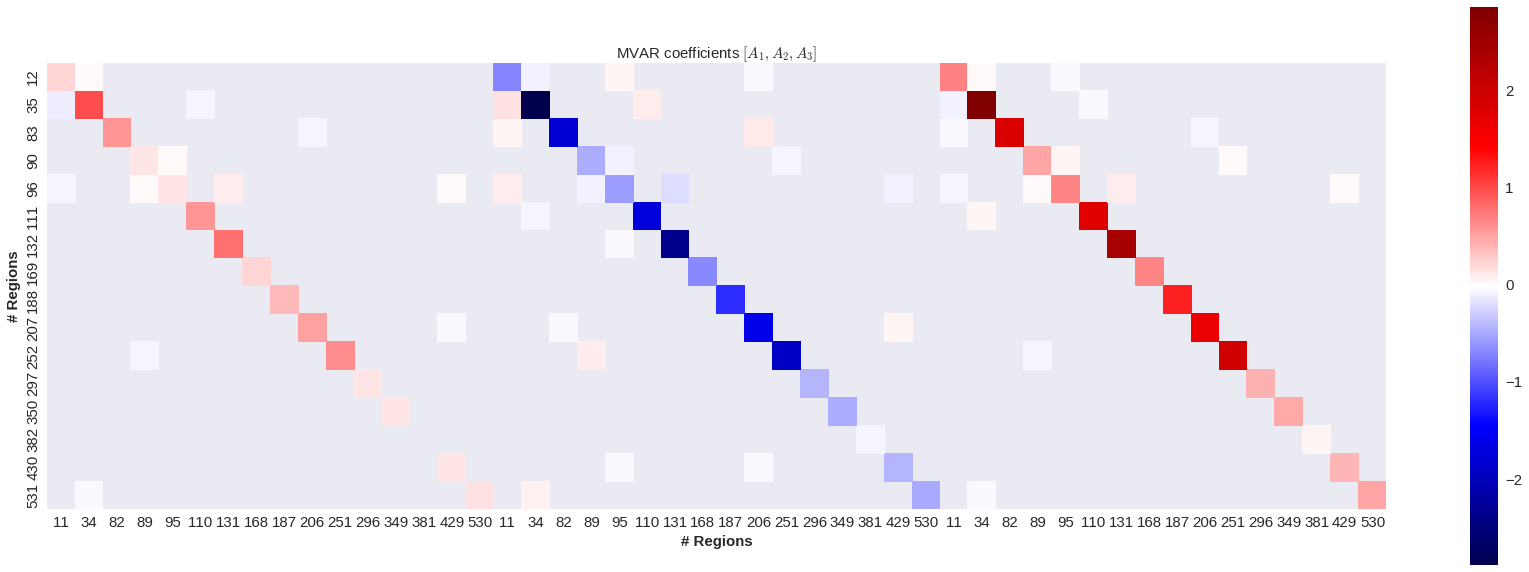

In [17]:
# after 4 iteration, we end up with 16 active regions (exe time few sec)
path = "results_p3_3.mat"
Result=spoi.loadmat(path)
S = Result['S estimate']
n_t_s, n_s = np.shape(S)
p=3
Sx = S.T.copy()
n_sources=[]
label = (Result['S Active']).astype(int)
p = 3
for i in range(3):
    n_sources.extend(label)
n_s = len(label)
MVAR = Result['S MVAR']
df = pd.DataFrame(MVAR, index = label+1, columns = n_sources)
m = np.where(np.absolute(MVAR)>1e-2*np.max(np.absolute(MVAR)))
mask = np.ones(np.shape(MVAR))
mask[m[0], m[1]] = 0

sns.plt.figure(figsize=(30,10))
sns.heatmap(df, square=True, cmap= "seismic", mask = mask)
sns.plt.xlabel("# Regions")
sns.plt.ylabel("# Regions")
sns.plt.title(r"MVAR coefficients $[A_1, A_2, A_3]$")
sns.plt.show()
path = "S1_data_p3.mat"
data=spoi.loadmat(path)
M = data['M']
G = data['G']
G_ac = G[:, label]
Me = np.dot(G_ac, S.T)
samples = np.array(data['time'][0])

# Brain network for the three time lags (black, blue, green)

In [18]:
from graphviz import Digraph

f = Digraph(engine='circo', filename='Brain_network.gv', format='png')
f.graph_attr.update(size="60,20")
LR = ['L','L','R','R','R','L','R','L','L','R','R','L','R','L','R','L']
for i in range(n_s):
    if (np.absolute(MVAR[i, :]) >= 1e-2).any():
        f.node(LR[i]+str(label[i]))
c_map = ['black', 'blue', 'green']
for k in range(p):
    print " Edges in ", c_map[k], " for time lag p = ", p-k
    for i in range(n_s):
        x = label[i]
        for j in range(n_s):
            y = label[j]
            z = '%.2f'%(MVAR[i, k*n_s + j])
            if (np.absolute(MVAR[i, k*n_s + j])>=1e-2):
                f.edge(LR[i]+str(x), LR[j]+str(y), label=str(z), color=c_map[k],fontsize="9.0")

f.view()

 Edges in  black  for time lag p =  3
 Edges in  blue  for time lag p =  2
 Edges in  green  for time lag p =  1


'Brain_network.gv.png'

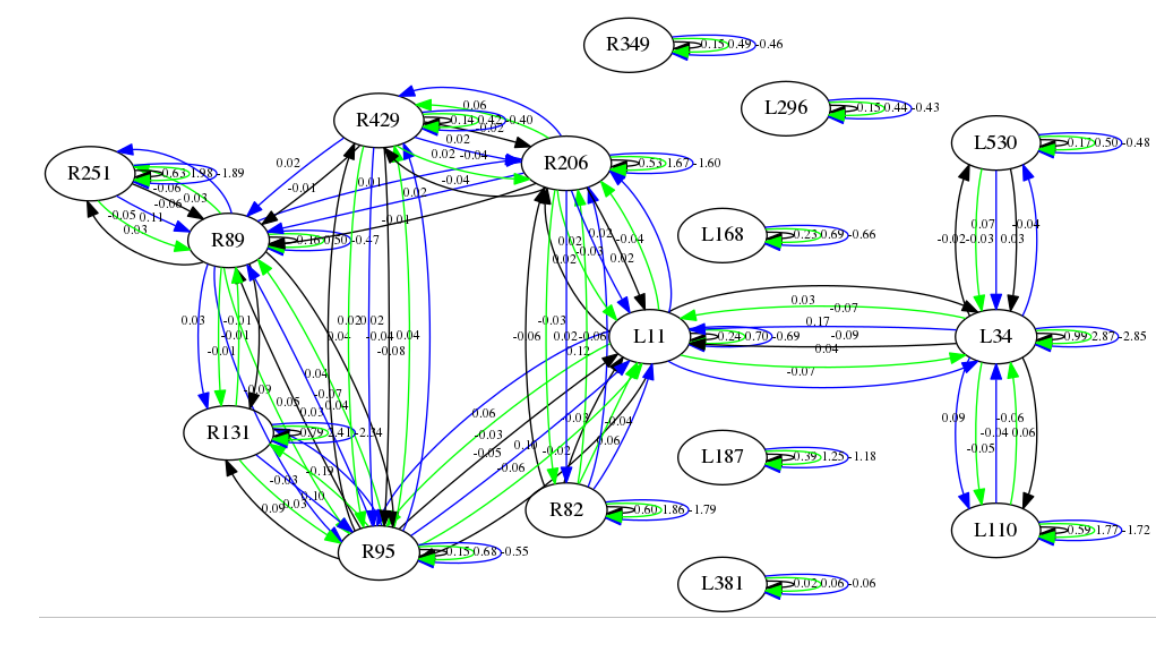

In [19]:
import matplotlib.image as mpimg
sns.plt.figure(figsize=(20,20))
img=mpimg.imread("Brain_network.gv.png")
sns.plt.imshow(img)
sns.plt.axis('off')
sns.plt.show()

# Normalized active brain regions
<img src="BrainActiveReg.png">

# Magnitude bias correction using least square 

In [11]:
parcellation = np.array(data['atlas'][0])
Coordinates = np.array(data['vertices'])
Faces = np.array(data['faces'])
Normals = np.array(data['normal'])
n_t, _ = np.shape(S)
n_reg = np.shape(G)[1]
H = np.zeros((n_reg, n_t))
H[label, :] = S.T
Z = np.zeros((n_reg+1, n_t))
Z[1:, :] = H
iSDR = S2H_sources(Z, parcellation)
scalar = np.linalg.norm(iSDR, axis=1)
if np.max(scalar) != 0.0:
    scalar /=np.max(scalar)

In [12]:
w = Result['Weights']
W = np.diag(w)
W = np.linalg.inv(W)
Gz = np.dot(G_ac, W)
X = np.dot(Gz, MVAR)
G_d = Construct_G_big(X, Sx, M[:, :], p)
Wx = (M.T).reshape(-1)
S_es = sp.sparse.linalg.lsmr(G_d, Wx, atol=1e-25, btol=1e-25)
S_es = S_es[0]
S_es = np.reshape(S_es, np.shape(Sx), order = 'F')

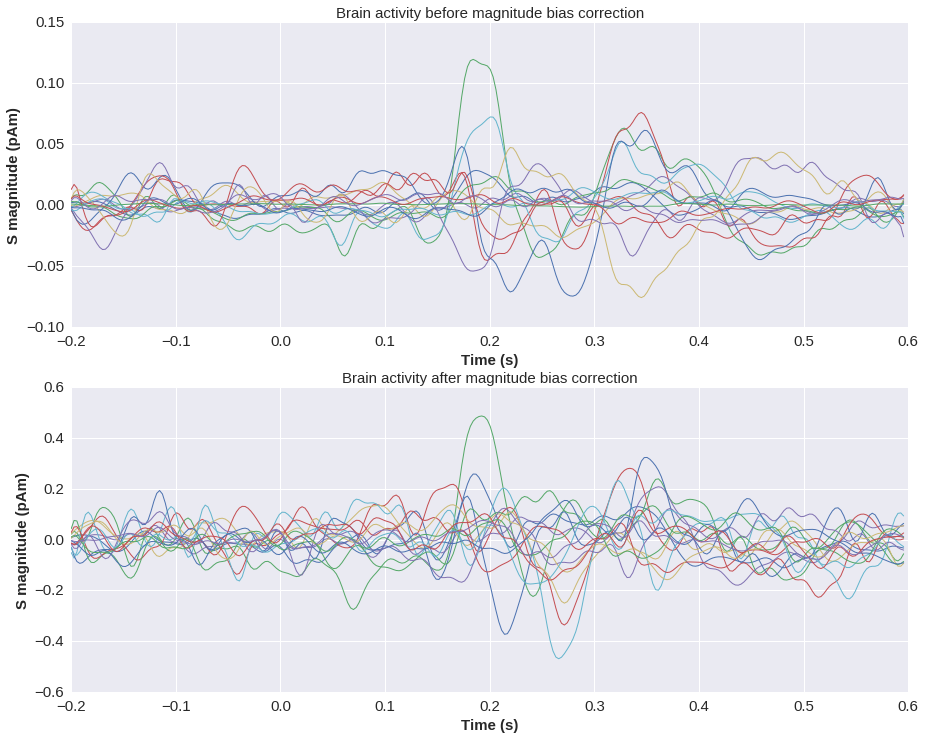

In [13]:
sns.plt.figure(figsize=(15,12))
sns.plt.subplot(211)
sns.plt.plot(samples[:-1], S[p:, :]*1e12)
sns.plt.ylabel("S magnitude (pAm)")
sns.plt.xlabel("Time (s)")
sns.plt.title("Brain activity before magnitude bias correction")
sns.plt.subplot(212)
sns.plt.plot(samples[:-1], S_es[:, p:].T*1e12)
sns.plt.ylabel("S magnitude (pAm)")
sns.plt.xlabel("Time (s)")
sns.plt.title("Brain activity after magnitude bias correction")
sns.plt.show()

# Right fusiform area activation (increase of activation after ~= 170ms)

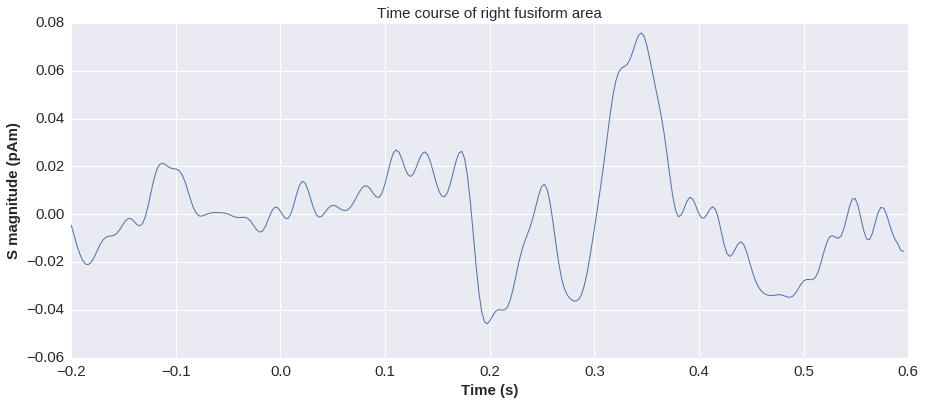

In [14]:
ffg = 2
sns.plt.figure(figsize=(15,6))
sns.plt.plot(samples[:-1], 1e12*Sx[ffg, p:].T)
sns.plt.ylabel("S magnitude (pAm)")
sns.plt.xlabel("Time (s)")
sns.plt.title("Time course of right fusiform area")
sns.plt.show()